In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
import lightgbm as lgb
import lightgbm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data_train = pd.read_csv("/Users/Harshitha/Downloads/santander-customer-transaction-prediction/train.csv")
data_test = pd.read_csv("/Users/Harshitha/Downloads/santander-customer-transaction-prediction/test.csv")
data_train.shape

(200000, 202)

In [3]:
data_test.shape

(200000, 201)

In [4]:
data_train.isnull().sum().sum()

0

In [5]:
X_train = data_train.drop(columns=['ID_code','target'])
y_train= data_train['target']
print(X_train.shape,y_train.shape)

(200000, 200) (200000,)


In [6]:
X_test = data_test.drop(columns=['ID_code'])
print(X_test.shape)

(200000, 200)


In [7]:
X_train.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [8]:
train_correlations = X_train.corr()
test_correlations = X_test.corr()
train_correlations = train_correlations.values.flatten()
test_correlations = test_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]
test_correlations = test_correlations[test_correlations != 1]


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


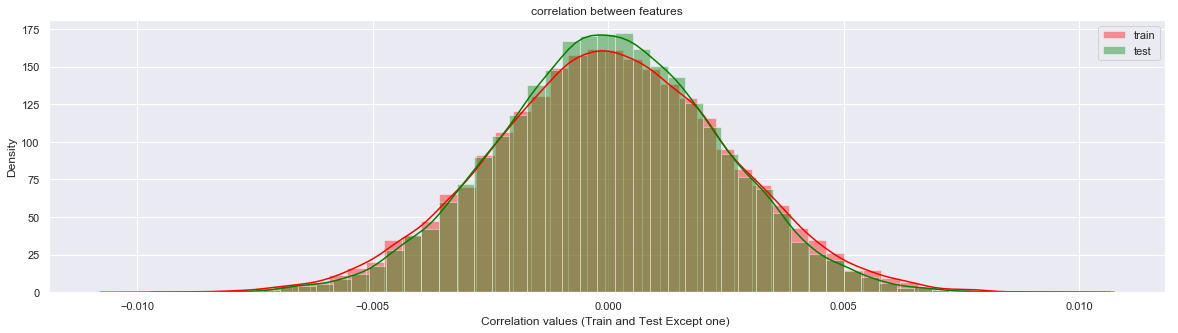

In [9]:
plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Red", label="train")
sns.distplot(test_correlations, color="Green", label="test")
plt.xlabel("Correlation values (Train and Test Except one) ")
plt.ylabel("Density")
plt.title("correlation between features"); 
plt.legend();

In [10]:
idx = features = X_train.columns.values
for df in [X_test, X_train]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

In [11]:
X_train.shape

(200000, 208)

In [12]:
X_test.shape

(200000, 208)

In [13]:
features =  X_train.columns.values
print(len(features))

208


In [14]:
param = {
    'bagging_freq': 6,
    'bagging_fraction': 0.5,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': 0,  
    'metric':'auc',
    'min_data_in_leaf': 78,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [15]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))

In [16]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(X_train.iloc[trn_idx][features], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx][features], label=y_train.iloc[val_idx])
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(X_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    predictions += clf.predict(X_test[features], num_iteration=clf.best_iteration) / folds.n_splits
    

Fold 0
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.899997	valid_1's auc: 0.881129
[2000]	training's auc: 0.91084	valid_1's auc: 0.887791
[3000]	training's auc: 0.918603	valid_1's auc: 0.892182
[4000]	training's auc: 0.924622	valid_1's auc: 0.894931
[5000]	training's auc: 0.929699	valid_1's auc: 0.896792
[6000]	training's auc: 0.93407	valid_1's auc: 0.898076
[7000]	training's auc: 0.938106	valid_1's auc: 0.898839
[8000]	training's auc: 0.941823	valid_1's auc: 0.899363
[9000]	training's auc: 0.945421	valid_1's auc: 0.89958
[10000]	training's auc: 0.948798	valid_1's auc: 0.899905
Did not meet early stopping. Best iteration is:
[10000]	training's auc: 0.948798	valid_1's auc: 0.899905
Fold 1
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.89977	valid_1's auc: 0.881652
[2000]	training's auc: 0.910619	valid_1's auc: 0.888913
[3000]	training's auc: 0.91849	valid_1's auc: 0.893194
[4000]	training's auc: 0.924701

In [42]:
predictions

array([0.10195761, 0.21302605, 0.19174548, ..., 0.00451427, 0.0963279 ,
       0.06054935])

In [18]:
print("CV score: {:<8.5f}".format(roc_auc_score(y_train, oof)))

CV score: 0.90022 


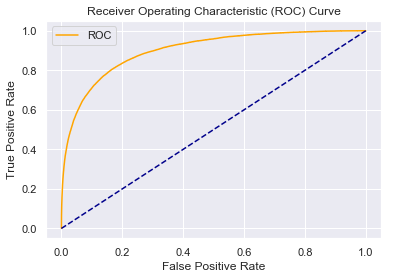

In [20]:
fpr, tpr, thresholds = roc_curve(y_train, oof)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [21]:
sub_df = pd.DataFrame({"ID_code":data_test["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_LGB_final.csv", index=False)